In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg as gb
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
import pandas as pd

In [2]:
from nltk.corpus import gutenberg
#print(gutenberg.fileids())
hamlet = gutenberg.words('shakespeare-hamlet.txt')  # 获取shakespeare-hamlet.txt这个文件的单词
print(hamlet)
hamlets = gutenberg.sents('shakespeare-hamlet.txt')  # 获取shakespeare-hamlet.txt这个文件的句子
print(hamlets)
send_table = [] # 得到text的二维str数组
text_string = '' # text纯string表示
p = ''',.";:'?()[]!`'''
for text_id in gutenberg.fileids()[0:5]:
    unit = gutenberg.sents(text_id)
    for s in hamlets:
        sent = []
        sent.append('<s')
        for word in s:
            if len(word)==1 and word in p:
                continue #在此增加if条件可以去除停用词等
            word = word.lower()
            sent.append(word)
            text_string+=word+' '
        sent.append('/s>')
        send_table.append(sent)

['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', 'William', 'Shakespeare', '1599', ']'], ['Actus', 'Primus', '.'], ...]


In [ ]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [ ]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

In [ ]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(text)]

In [ ]:
import string
sent_t = []
for w_l in tokenized_text:
    sent_t.append(' '.join(w_l).replace(',','').replace('- ','').replace('.','').replace('  ',' '))
d = {'sentence':sent_t}
sent_table = pd.DataFrame(d)
sent_list = []
for sent in sent_table['sentence']:
    w_list = []
    for word in sent.split(' '):
        w_list.append(str(word))
    sent_list.append(w_list)
sent_table.head()

In [3]:
word_list =[n for a in send_table for n in a]
word_set=set(word_list)

In [4]:
# 对text_string进行词频统计
word_list = []
cnt_list = []
text_tokenized = nltk.word_tokenize(text_string)
#print(text_tokenized)   
from nltk import FreqDist
fdist = FreqDist(text_tokenized)
print(fdist)
for a,b in fdist.items():
    word_list.append(str(a))
    cnt_list.append(b)
dic = {
    'word':word_list,
    'cnt':cnt_list
}
info_table = pd.DataFrame(dic)
info_table.head(10)

<FreqDist with 4706 samples and 152240 outcomes>


,word,cnt
0,the,4965
1,tragedie,20
2,of,3050
3,hamlet,500
4,by,535
5,william,5
6,shakespeare,5
7,1599,5
8,actus,10
9,primus,5


In [5]:
# Preprocess the tokenized text for 3-grams language modelling
# send_table: list[list(str)]
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, send_table)

In [6]:
# 使用nltk 的ngram模型
from nltk.lm import MLE
model = MLE(n) # Lets train a 3-grams model, previously we set n=3

In [7]:
model.fit(train_data, padded_sents)
print(model.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 4710 items>


In [9]:
model.logscore('william',['hamlet','by'])

0.0

In [10]:
word2sum = {}
word_set = set()
for sent in send_table:
    w1=''
    w2=''
    for word in sent:
        if w2 == '':
            log_prob = -model.logscore(word)
        elif w1 == '':
            log_prob = -model.logscore(word,[w2])
        else:
            log_prob = -model.logscore(word,[w1,w2])
        print(log_prob)
        if word in word2sum:
            word2sum[word] += log_prob
        else:
            word2sum[word] = 0
        w1 = w2
        w2 = word

3.981211637137156
5.956985924612576
4.643856189774724
-0.0
-0.0
2.321928094887362
-0.0
-0.0
-0.0
-0.0
3.981211637137156
10.600842114387302
1.0
-0.0
3.981211637137156
11.600842114387303
-0.0
-0.0
3.981211637137156
5.278914019499939
6.321928094887362
-0.0
1.0
-0.0
-0.0
-0.0
3.981211637137156
10.015879613666145
0.5849625007211563
3.981211637137156
7.693951518778784
3.9068905956085187
-0.0
-0.0
3.981211637137156
8.793487192329698
-0.0
3.981211637137156
7.015879613666145
4.584962500721157
-0.0
1.0
-0.0
-0.0
-0.0
-0.0
2.321928094887362
3.981211637137156
8.793487192329698
-0.0
3.981211637137156
10.600842114387302
1.0
-0.0
2.0
2.0
3.981211637137156
8.793487192329698
-0.0
3.981211637137156
10.015879613666145
0.5849625007211563
3.981211637137156
8.793487192329698
-0.0
3.981211637137156
6.956985924612576
4.643856189774724
3.981211637137156
8.793487192329698
-0.0
3.981211637137156
6.646645804000426
4.954196310386876
1.0
-0.0
-0.0
-0.0
2.0
-0.0
3.981211637137156
8.793487192329698
-0.0
3.98121163713

In [11]:
#增加词长、计算信息量
word_count_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    word_count = len(word)  
    word_count_table = word_count_table.append(pd.DataFrame({'len':word_count}, index=[n]))
info_table['len'] = word_count_table['len']
sum_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    if word not in word2sum:
        sum_table = sum_table.append(pd.DataFrame({'sum':-1}, index=[n]))
        continue
    sum_proc = word2sum[word]
    sum_table = sum_table.append(pd.DataFrame({'sum':sum_proc}, index=[n]))
info_table['sum_neg_log_prob'] = sum_table['sum']
info_table['averge_content'] = (info_table['sum_neg_log_prob']/info_table['cnt'])
info_table.head(30)

,word,cnt,len,sum_neg_log_prob,averge_content
0,the,4965,3,4875.457141,0.981965
1,tragedie,20,8,46.794706,2.339735
2,of,3050,2,1129.964760,0.370480
3,hamlet,500,6,1078.749888,2.157500
4,by,535,2,679.044427,1.269242
5,william,5,7,0.000000,0.000000
6,shakespeare,5,11,0.000000,0.000000
7,1599,5,4,0.000000,0.000000
8,actus,10,5,95.407579,9.540758
9,primus,5,6,4.000000,0.800000


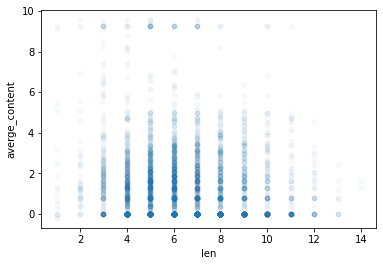

In [20]:
info_table.plot.scatter(x="len", y="averge_content", alpha=0.03)
info_table.sort_values(by='len',ascending='False')
long_word = list(info_table[info_table['len']>10]['word'])